# Importing libraries

In [1]:
library(readxl)
library(dplyr)
library(caTools)
library(MASS)
library(leaps)
library(glmnet)
library(ISLR)
library(car)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select


Loading required package: Matrix

Loaded glmnet 3.0-1


Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode




# Loading the data

In [2]:
train = read.csv("../input/big-mart-sales-prediction/Train.csv")
test = read.csv("../input/big-mart-sales-prediction/Test.csv")

In [3]:
head(train, 3)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
,<fct>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<int>,<fct>,<fct>,<fct>,<dbl>
1,FDA15,9.30,Low Fat,0.01604730,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
2,DRC01,5.92,Regular,0.01927822,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
3,FDN15,17.50,Low Fat,0.01676007,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700


# Data Preprocessing

In [4]:
Item_Outlet_Sales = 0
test = cbind(test, Item_Outlet_Sales)

In [5]:
data = rbind(train, test)

colSums(is.na(data))

Item_Identifier               Item_Weight          Item_Fat_Content 
                        0                      2439                         0 
          Item_Visibility                 Item_Type                  Item_MRP 
                        0                         0                         0 
        Outlet_Identifier Outlet_Establishment_Year               Outlet_Size 
                        0                         0                         0 
     Outlet_Location_Type               Outlet_Type         Item_Outlet_Sales 
                        0                         0                         0

In [6]:
data = data %>% mutate(Item_Weight=replace(Item_Weight, is.na(Item_Weight), round(mean(Item_Weight, na.rm = T),2)))

In [7]:
summary(as.factor(data$Outlet_Size))
data$Outlet_Size = ifelse(data$Outlet_Size=='Small','Small',ifelse(data$Outlet_Size=='High','High', 'Medium'))
summary(as.factor(data$Outlet_Size))

High Medium  Small 
  4016   1553   4655   3980

High Medium  Small 
  1553   8671   3980

In [8]:
sum(is.na(data))

[1] 0

In [9]:
summary(as.factor(data$Item_Fat_Content))
data$Item_Fat_Content = ifelse(data$Item_Fat_Content=='LF' | data$Item_Fat_Content=='low fat','Low Fat',
                          ifelse(data$Item_Fat_Content=='reg' | data$Item_Fat_Content=='Regular','Regular', 
                                 'Low Fat'))

LF low fat Low Fat     reg Regular 
    522     178    8485     195    4824

In [10]:
summary(as.factor(data$Item_Fat_Content))
summary(as.factor(data$Outlet_Size))
summary(as.factor(data$Item_Type))
summary(as.factor(data$Outlet_Identifier))
summary(as.factor(data$Outlet_Location_Type))
summary(as.factor(data$Outlet_Type))

Low Fat Regular 
   9185    5019

High Medium  Small 
  1553   8671   3980

Baking Goods                Breads             Breakfast 
                 1086                   416                   186 
               Canned                 Dairy          Frozen Foods 
                 1084                  1136                  1426 
Fruits and Vegetables           Hard Drinks    Health and Hygiene 
                 2013                   362                   858 
            Household                  Meat                Others 
                 1548                   736                   280 
              Seafood           Snack Foods           Soft Drinks 
                   89                  1989                   726 
        Starchy Foods 
                  269

OUT010 OUT013 OUT017 OUT018 OUT019 OUT027 OUT035 OUT045 OUT046 OUT049 
   925   1553   1543   1546    880   1559   1550   1548   1550   1550

Tier 1 Tier 2 Tier 3 
  3980   4641   5583

Grocery Store Supermarket Type1 Supermarket Type2 Supermarket Type3 
             1805              9294              1546              1559

# Applying one-hot encoding

In [11]:
Item_Outlet_Sales = data$Item_Outlet_Sales
data = as.data.frame(model.matrix(Item_Outlet_Sales ~ .-Item_Identifier, data = data)[,-1])
data = cbind(data, Item_Outlet_Sales)

# Seperating train and test data

In [12]:
train_ = data[1:nrow(train),]
test_ = data[(nrow(train) + 1):nrow(data),]

# Seperating train data into train_test_split for validation of model

In [13]:
set.seed(123)
split = sample.split(train_$Item_Outlet_Sales, SplitRatio = 0.8)
training_set = subset(train_, split==TRUE)
testing_set = subset(train_, split==FALSE)

In [14]:
X = model.matrix(Item_Outlet_Sales ~ ., data = training_set)[,-1]
X_test = model.matrix(Item_Outlet_Sales ~ ., data = testing_set)[,-1]

# Applying Linear Regression

In [15]:
# Linear Regression
lm.fit = lm(Item_Outlet_Sales ~ ., data = training_set)
summary(lm.fit)
pred_lm = predict(lm.fit, newx = X_test)
sqrt(mean((testing_set$Item_Outlet_Sales - pred_lm)^2))


Call:
lm(formula = Item_Outlet_Sales ~ ., data = training_set)

Residuals:
    Min      1Q  Median      3Q     Max 
-4479.3  -708.8   -92.1   595.8  7833.1 

Coefficients: (8 not defined because of singularities)
                                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)                      -1878.7370    92.2964 -20.355   <2e-16 ***
Item_Weight                         -2.4048     3.2748  -0.734    0.463    
Item_Fat_ContentRegular             45.5512    31.4781   1.447    0.148    
Item_Visibility                   -296.1527   277.1799  -1.068    0.285    
Item_TypeBreads                     -9.2965    93.2784  -0.100    0.921    
Item_TypeBreakfast                  59.7554   127.3695   0.469    0.639    
Item_TypeCanned                     32.5027    69.9549   0.465    0.642    
Item_TypeDairy                     -62.7956    69.3723  -0.905    0.365    
`Item_TypeFrozen Foods`            -59.4464    65.5829  -0.906    0.365    
`Item_TypeFruits and Veget

Warning message in testing_set$Item_Outlet_Sales - pred_lm:
“longer object length is not a multiple of shorter object length”


[1] 1906.737

**It can be observed that linear regression would not be the best model to predict the sales, as there are some variables which are not significant in the model (i.e. their p-values are greater than 0.05), also the Adjusted R-squared and RMSE are low and high respectively. **

** Hence, model can be more tuned by applying subsetting among the variables, so that best model can be picked.**

# Applying Backward Subsetting

**For the data, backward subsetting is getting more good results, that too with only 10 models, as there are some linear dependencies available among the data.**

In [16]:
# Subsetting

nvmax_ = 10

subset.fit = regsubsets(Item_Outlet_Sales ~ ., data = training_set, method='backward', nvmax = nvmax_)
k = summary(subset.fit)
k$adjr2[which.max(k$adjr2)]

Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
“8  linear dependencies found”


[1] 0.5681359

In [17]:
val.errors = rep(NA, nvmax_)
for(i in 1:nvmax_){
  coefi = coef(subset.fit, id=i)
  pred = cbind(1, X_test[,names(coefi[-c(1)])]) %*% coefi
  val.errors[i]= sqrt(mean((testing_set$Item_Outlet_Sales - pred) ^2))
}
val.errors
"Best RMSE Value"
val.errors[which.min(val.errors)]

[1] 1166.0001 1111.0935 1104.0349 1095.5755 1081.8213 1070.8155 1060.9772
 [8] 1012.9980  949.7667  949.9237

[1] "Best RMSE Value"

[1] 949.7667

# Applying Lasso Regression

**User defined lambda are generated because, system lambda are not giving good results, hence 100 sequence are generated from 1e10 to 0.02**

Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”


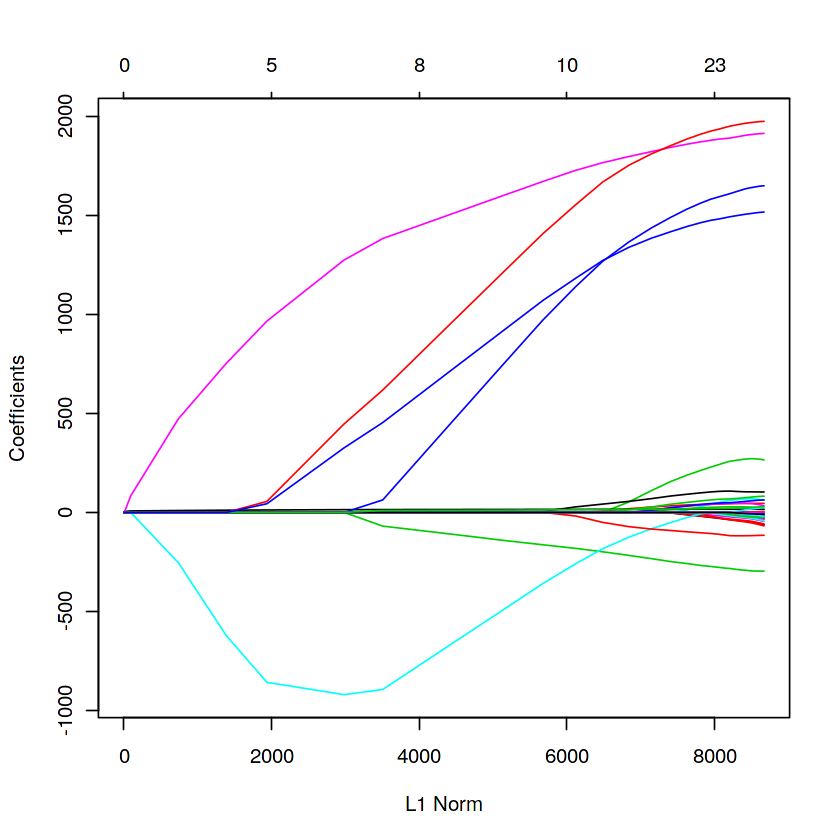

In [18]:
# Ridge and Lasso

ld = 10^seq(10, -2, length=100)

y = training_set$Item_Outlet_Sales
rig.fit = glmnet(X, y, alpha=1, lambda=ld)
plot(rig.fit)

**From the above graph it can be observed that many variables are tending towards zero which represents that these variables can be neglected and will not affect the model accuracy, also this can lead to minimum RMSE.**

**Applying 5-fold Cross Validation in the model**

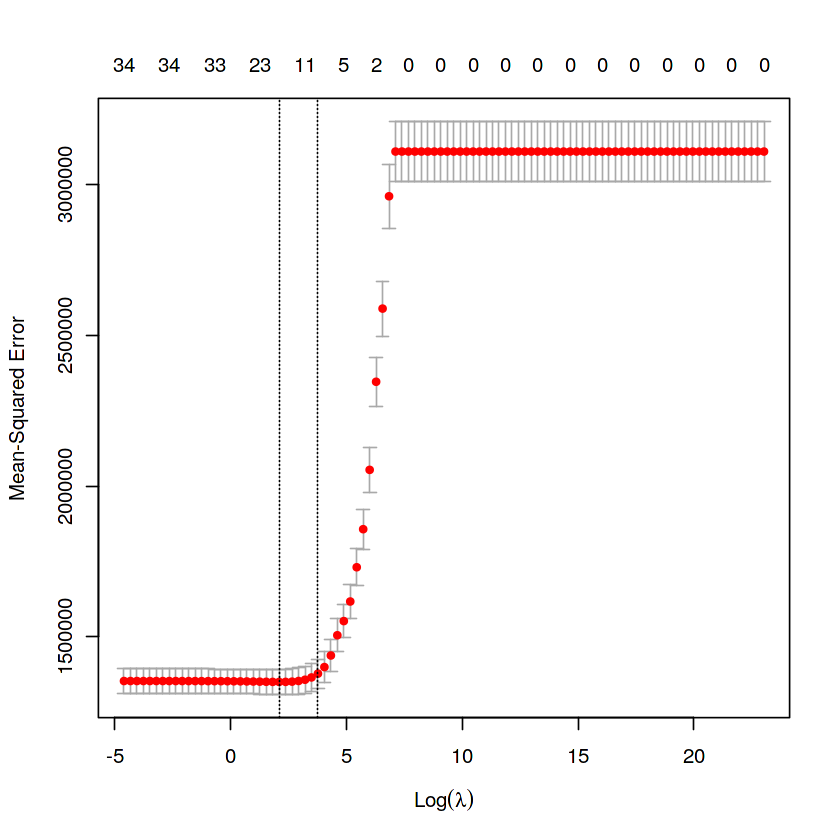

In [19]:
cvglm = cv.glmnet(X, y, alpha=1, lambda=ld, nfolds=5)
plot(cvglm)

In [20]:
best = cvglm$lambda.min
best

[1] 8.111308

**Best lambda generated from the lambda sequence which gives the best model.**

In [21]:
predict(rig.fit, s=best, type='coefficients')

37 x 1 sparse Matrix of class "dgCMatrix"
                                             1
(Intercept)                      -1799.5553443
Item_Weight                         -0.5008405
Item_Fat_ContentRegular             37.6270631
Item_Visibility                   -257.7754311
Item_TypeBreads                      .        
Item_TypeBreakfast                  12.1814693
Item_TypeCanned                     31.3087109
Item_TypeDairy                     -11.3826903
`Item_TypeFrozen Foods`            -10.6721046
`Item_TypeFruits and Vegetables`    19.5917103
`Item_TypeHard Drinks`               .        
`Item_TypeHealth and Hygiene`        .        
Item_TypeHousehold                  -3.2016368
Item_TypeMeat                        .        
Item_TypeOthers                      .        
Item_TypeSeafood                   187.3085422
`Item_TypeSnack Foods`               .        
`Item_TypeSoft Drinks`               .        
`Item_TypeStarchy Foods`             .        
Item_MRP          

**Some of the variables which tends to zero, which can be neglected.**

In [22]:
pred_rl = predict(rig.fit, s=best, newx = X_test)
sqrt(mean((testing_set$Item_Outlet_Sales - pred_rl)^2))

[1] 946.5096

# Writing the Submission File

In [23]:
# Predicting the test set
test_set = model.matrix(Item_Outlet_Sales ~ ., data = test_)[,-1]
pred_test = predict(rig.fit, s=best, newx = test_set)

submission = data.frame('Item_Identifier'=test$Item_Identifier,
                        'Outlet_Identifier'=test$Outlet_Identifier,pred_test)
names(submission)[3] = 'Item_Outlet_Sales'

In [24]:
write.csv(submission, 'Ridge_Lasso.csv', row.names = F)